In [10]:
import pandas as pd

df = pd.read_csv('data.csv')  # read df from csv file

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H;%M:%S')
df = df.drop(columns=['Date', 'Time'])
df.set_index('Datetime', inplace=True)

# using month and hour as features
df['Month'], df['Day'], df['Hour']  = df.index.month, df.index.day, df.index.hour 

print(df[:5])

                      Load  Month  Day  Hour
Datetime                                    
2007-10-01 00:00:00  1.324     10    1     0
2007-10-01 00:01:00  1.320     10    1     0
2007-10-01 00:02:00  1.318     10    1     0
2007-10-01 00:03:00  1.320     10    1     0
2007-10-01 00:04:00  1.312     10    1     0


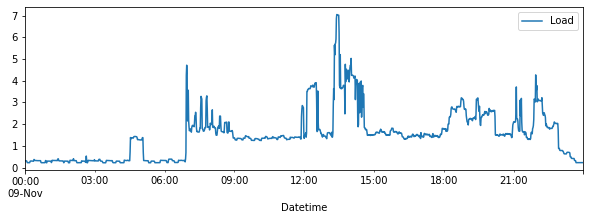

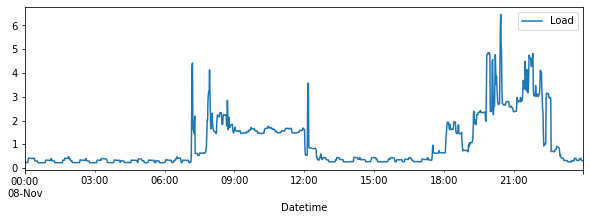

In [11]:
target_date=['2007-11-09', '2007-11-08']

def plot_data(df, target_date):
    for tar in target_date:
        one_day_data = df.loc[tar]
        one_day_data.plot(y='Load', figsize=(10, 3))

plot_data(df, target_date)

In [12]:
import numpy as np
import torch
from demand_utils import *

device="cuda"

# preprocessing
preprocess_info = {}
for col in ['Month', 'Day', 'Hour']:
    preprocess_info[col] = (df[col].mean(), df[col].std())
    df[col] = (df[col] - df[col].mean()) / df[col].std()
    
print(preprocess_info)

n_train = int(len(df) * 0.8)
train_features = torch.tensor(df.iloc[:n_train, 1:].values, dtype=torch.float32, device=device)
test_features = torch.tensor(df.iloc[n_train:, 1:].values, dtype=torch.float32, device=device)
train_labels = torch.tensor(df.iloc[:n_train, 0].values.reshape(-1, 1), dtype=torch.float32, device=device)
test_labels = torch.tensor(df.iloc[n_train:, 0].values.reshape(-1, 1), dtype=torch.float32, device=device)
print(train_features.shape, train_labels.shape)

{'Month': (6.5136612021857925, 3.451237192257619), 'Day': (15.756830601092895, 8.811537990337259), 'Hour': (11.5, 6.922193119482051)}
torch.Size([421632, 3]) torch.Size([421632, 1])


In [13]:
demand_dataset = Demand_Dataset(train_features, train_labels)
demand_dataloader = DataLoader(demand_dataset, batch_size=36, shuffle=True)
demand_model = Demand_Model(device)

# training
num_epochs = 100
for epoch in range(num_epochs):
    for batch_idx, (features, labels) in enumerate(demand_dataloader):
        loss = demand_model.update(features, labels)
    print(loss)
    
torch.save(demand_model.state_dict(), 'demand_model_weights.pth')

tensor(0.7334, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9907, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9232, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.8471, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6256, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9515, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9565, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.6587, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9502, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9279, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9271, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.8717, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3225, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.8240, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7607, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7724, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0497, device='cuda:0', grad_fn=

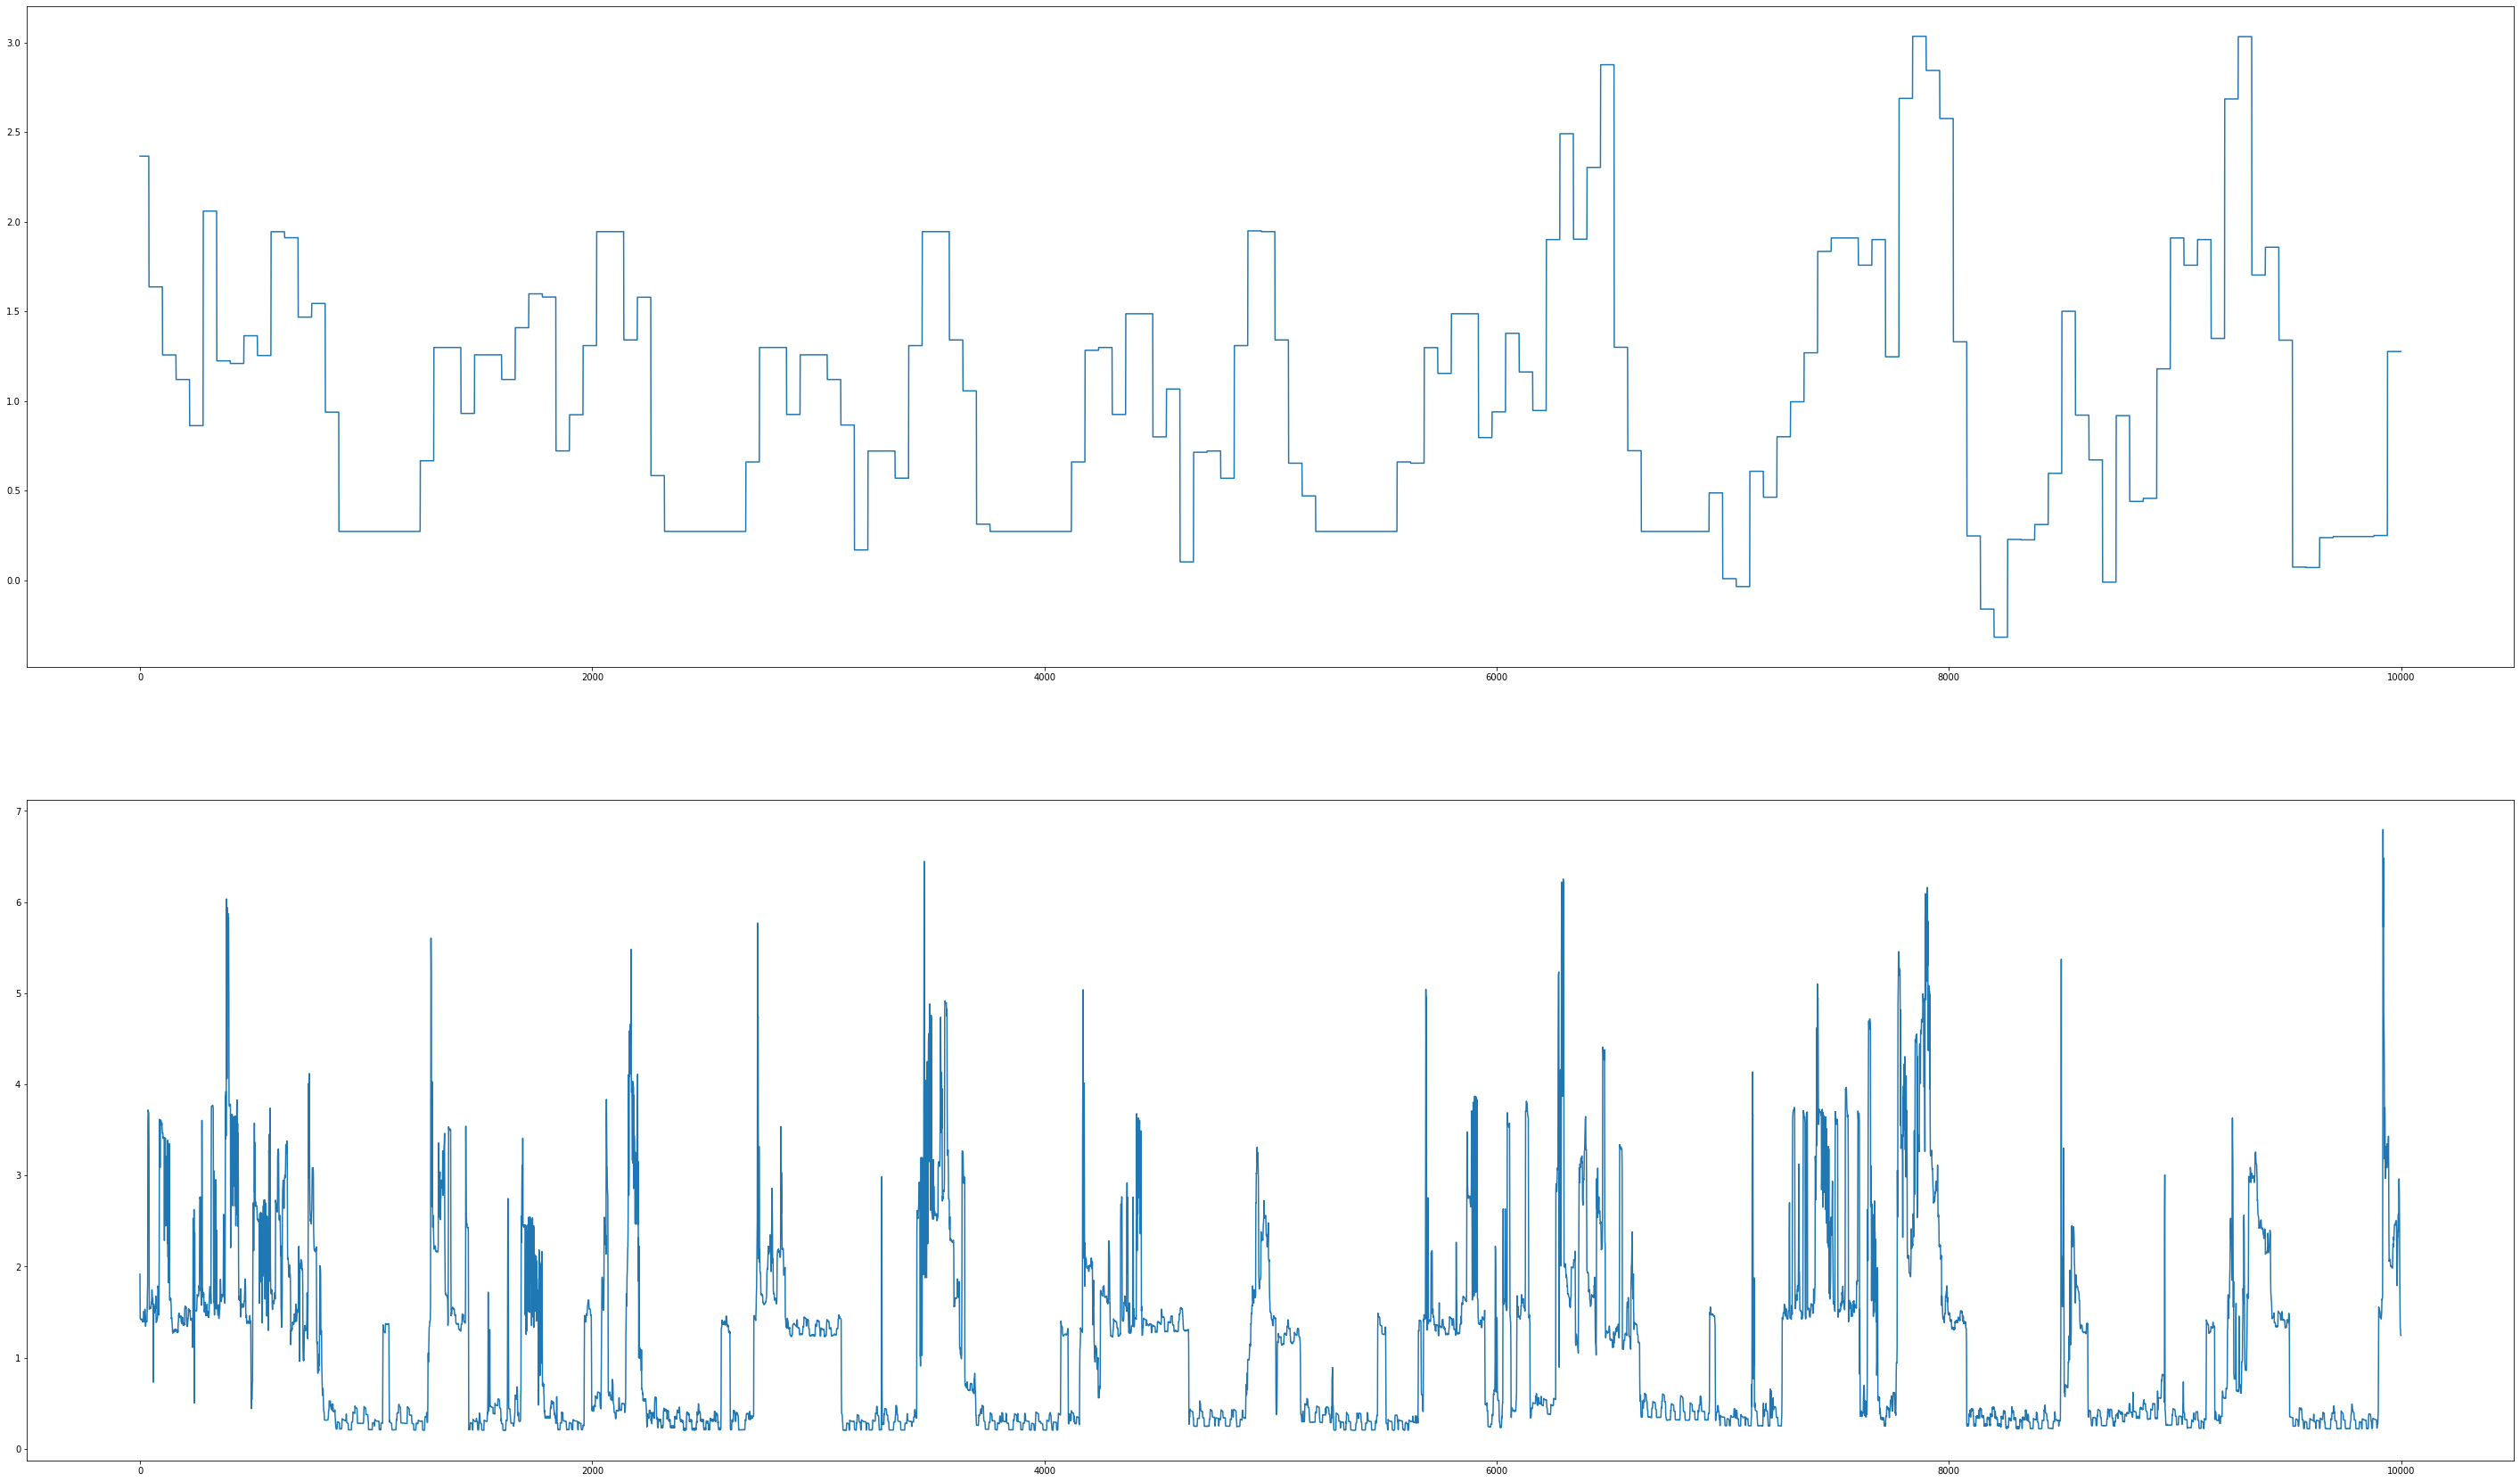

In [14]:
# testing
import matplotlib.pyplot as plt
pred_vals = []
real_vals = []

start = 2000
steps = 10000

for i in range(start, start + steps):
    pred = demand_model.transition_step(train_features[i])
    pred_vals.append(pred.item())
    real_vals.append(train_labels[i].item())

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(30)
fig.set_figwidth(50)
ax1.plot(np.arange(0, steps), pred_vals, label='Predicted')
ax2.plot(np.arange(0, steps), real_vals, label='Actual')